In [4]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.similarity import graph_edit_distance
import math


warnings.filterwarnings("ignore")

In [30]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [31]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [32]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [33]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.3))
    return km.to_nx(graph)

In [38]:
def calc_average_for_hop(hop,ref_graph,n,p,delta_n,delta_p):
    sum_original = 0
    sum_TDA = 0
    counter = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = nx.erdos_renyi_graph(i*delta_n + n,j*delta_p + p)
                TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(ref_graph, neighbour)
                
                sum_TDA += score_TDA
                sum_original += score_original
                counter += 1
    return {"hop:" : hop,"TDA": sum_TDA/counter,"original": sum_original/counter}
                

In [35]:
def conduct_test_for_on_graph(graph,n,p,delta_n,delta_p,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,p = p,delta_n = delta_n,delta_p = delta_p)
    return {"n" : n,"p" : p,"Result" : result}
    

In [46]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('p')
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
        
    for i in range(sample_numbers):
        row =[]
        n = random.randint(30,50)       
        p = round(random.uniform(21, 40))/100
        row.append(n)
        row.append(p)
        reference_graph = nx.erdos_renyi_graph(n,p)
        result = conduct_test_for_on_graph(reference_graph,n,p,2,0.05,n_hop)['Result']

        for j in range(n_hop):
            row.append(result[j]['original'])
            row.append(result[j]['TDA'])
        row_list.append(row)
        print("Done:" + str(i+1) + "/" +  str(sample_numbers))
       
    df = pd.DataFrame(row_list,columns= column)
    
    return df
        

In [47]:
df = conduct_test_on_sample(30,4)
print(df)

Done:1/30
Done:2/30
Done:3/30
Done:4/30
Done:5/30
Done:6/30
Done:7/30
Done:8/30
Done:9/30
Done:10/30
Done:11/30
Done:12/30
Done:13/30
Done:14/30
Done:15/30
Done:16/30
Done:17/30
Done:18/30
Done:19/30
Done:20/30
Done:21/30
Done:22/30
Done:23/30
Done:24/30
Done:25/30
Done:26/30
Done:27/30
Done:28/30
Done:29/30
Done:30/30
     n     p  Original_1      TDA_1  Original_2      TDA_2   Original_3  \
0   43  0.36  246.834363   7.757776  530.146686   7.549241  1214.392091   
1   38  0.34  109.349541  12.445517  372.685176  13.084302   848.019708   
2   42  0.28  144.218566  10.510292  516.416411   9.715655   945.599280   
3   46  0.29  193.404144   6.636335  593.955392  11.147578  1334.977459   
4   44  0.29  160.258000  10.424263  545.690410  17.880047  1224.164363   
5   49  0.31  317.015239   8.752992  901.791019  13.089569  1766.361636   
6   47  0.22  227.596789  10.518089  727.158419  10.137342  1362.045862   
7   45  0.38  181.024641  15.025286  618.810692   7.805347  1302.409346   
8   

In [48]:
df.to_csv("30_sample_graphs-ER.csv")

In [49]:
df

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,43,0.36,246.834363,7.757776,530.146686,7.549241,1214.392091,11.320279,1991.314007,12.608134
1,38,0.34,109.349541,12.445517,372.685176,13.084302,848.019708,11.007104,1479.288875,12.461456
2,42,0.28,144.218566,10.510292,516.416411,9.715655,945.599280,11.852701,1854.003271,12.090326
3,46,0.29,193.404144,6.636335,593.955392,11.147578,1334.977459,12.118363,2399.556685,10.629082
4,44,0.29,160.258000,10.424263,545.690410,17.880047,1224.164363,14.310623,2012.156552,10.477194
5,49,0.31,317.015239,8.752992,901.791019,13.089569,1766.361636,12.541958,3009.327403,11.258657
6,47,0.22,227.596789,10.518089,727.158419,10.137342,1362.045862,9.292534,2592.644157,15.035428
7,45,0.38,181.024641,15.025286,618.810692,7.805347,1302.409346,10.125338,2227.295456,10.637895
8,45,0.24,168.989990,11.834480,564.814327,10.277094,1364.729941,12.425913,2147.085251,11.277626
9,33,0.34,117.902655,8.786017,235.157158,12.661404,498.314490,10.736076,887.554974,12.078992


In [3]:

df_read = pd.read_csv('30_sample_graphs-ER.csv',index_col=False)
df_read.drop(columns=['Unnamed: 0'])

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,43,0.36,246.834363,7.757776,530.146686,7.549241,1214.392091,11.320279,1991.314007,12.608134
1,38,0.34,109.349541,12.445517,372.685176,13.084302,848.019708,11.007104,1479.288875,12.461456
2,42,0.28,144.218566,10.510292,516.416411,9.715655,945.599280,11.852701,1854.003271,12.090326
3,46,0.29,193.404144,6.636335,593.955392,11.147578,1334.977459,12.118363,2399.556685,10.629082
4,44,0.29,160.258000,10.424263,545.690410,17.880047,1224.164363,14.310623,2012.156552,10.477194
5,49,0.31,317.015239,8.752992,901.791019,13.089569,1766.361636,12.541958,3009.327403,11.258657
6,47,0.22,227.596789,10.518089,727.158419,10.137342,1362.045862,9.292534,2592.644157,15.035428
7,45,0.38,181.024641,15.025286,618.810692,7.805347,1302.409346,10.125338,2227.295456,10.637895
8,45,0.24,168.989990,11.834480,564.814327,10.277094,1364.729941,12.425913,2147.085251,11.277626
9,33,0.34,117.902655,8.786017,235.157158,12.661404,498.314490,10.736076,887.554974,12.078992


In [5]:
original_1 = df_read['Original_1'].tolist()
original_1

[74.2864620185085,
 160.14393768008327,
 114.92761463939716,
 142.61904443058637,
 96.52263440465688,
 65.91075693361746,
 100.41489114492984,
 89.94098372025684,
 203.42128090645912,
 119.87629441357493,
 91.6753316797358,
 56.97413333911824,
 181.6842541657284,
 218.39156069049935,
 169.8323060109287,
 133.93649495133167,
 82.81938628772349,
 140.76082834725932,
 209.10901507633736,
 132.86259966138613,
 191.7674967839976,
 178.94744588137956,
 148.74597293016325,
 77.13710673420566,
 75.50704156477549,
 123.5875820712572,
 79.76413578123733,
 251.6725748663565,
 176.72987060000358,
 153.05009622252643]

In [6]:
original_average =[]
TDA_avaerage = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
    original_average.append(round(math.log10(original_sum/len(original_list)),2))
    TDA_avaerage.append(round(tda_sum/len(tda_list),2))
    
  
        

In [7]:
original_average

[2.18, 2.66, 2.99, 3.23]

In [8]:
TDA_avaerage

[10.06, 11.93, 11.51, 12.46]

<AxesSubplot:>

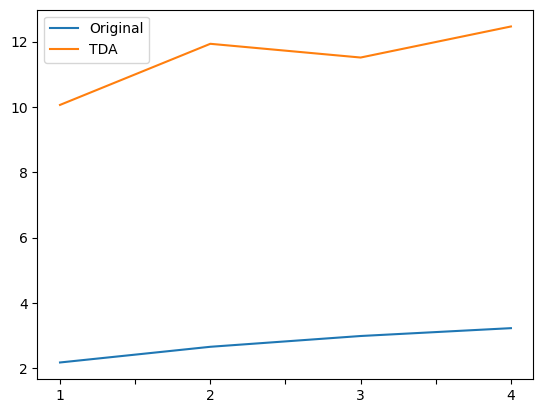

In [9]:
average_df = pd.DataFrame({'Original' : original_average,'TDA': TDA_avaerage},index=['1','2','3','4'])
average_df.plot.line()

In [54]:
orignal_df = pd.DataFrame({'Original' : original_average},index=[1,2,3,4])

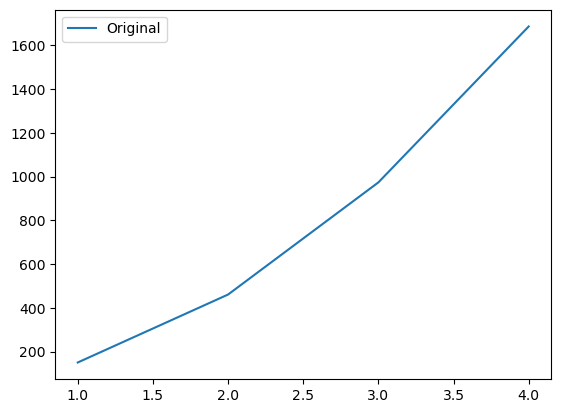

In [55]:
lines = orignal_df.plot.line()

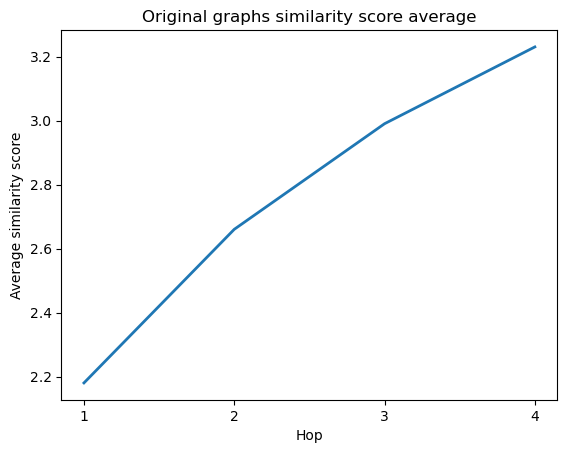

In [11]:
hop = ['1','2','3','4']
plt.plot(hop, original_average,linewidth=2, markersize=12)
plt.title('Original graphs similarity score average')
plt.xlabel('Hop')
plt.ylabel('Average similarity score')
plt.savefig("original.jpg")
plt.show()

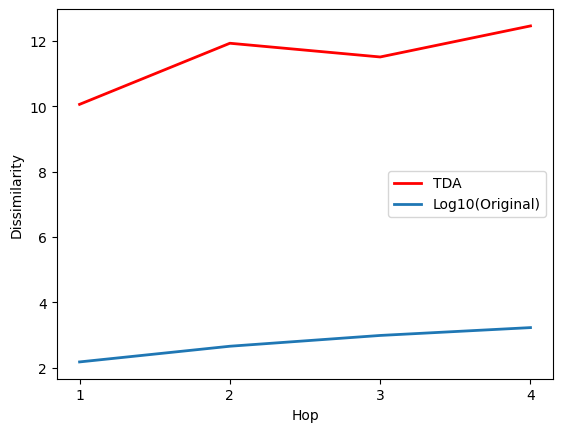

In [20]:
plt.plot(hop, TDA_avaerage,linewidth=2, markersize=12,color='red',label ="TDA")
plt.plot(hop, original_average,linewidth=2, markersize=12, label="Log10(Original)")
plt.xlabel('Hop')
plt.ylabel('Dissimilarity')
plt.legend()
plt.savefig("TDA-Original-ER.jpg")
plt.show()